In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynumdiff
from pybounds import SlidingEmpiricalObservabilityMatrix, SlidingFisherObservability
from utils import figure_functions as ff
from model import drone_model_kinematic
from model.drone_model_kinematic import DroneSimulator
from utils import util
from utils import consensus
import math

%reload_ext autoreload
%autoreload 2

/home/jaden/repos/conSensus/.venv/lib/python3.10/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/jaden/repos/conSensus/.venv/lib/python3.10/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')
/home/jaden/repos/conSensus/.venv/lib/python3.10/site-packages/figurefirst/mpl_fig_to_figurefirst_svg.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<

# Set trajectory


In [2]:
# Time
dt = 0.1  # sampling time [s]
fs = 1 / dt  # sampling frequency [hz]
T = 11.0  # total time [s]
tsim = np.arange(0, T + dt/2, step=dt) # time vector [s]

In [3]:
# Set the ambient wind
w = 1.0 * np.ones_like(tsim)
# w = 1.0 + 0.4*np.sin(2*np.pi*(0.8/T)*tsim)
zeta = (np.pi/2) * np.ones_like(tsim)
# zeta = (np.pi/1.5)*np.sin(2*np.pi*(0.5/T)*tsim + np.pi/4)

# Set altitude
z =  2.0 * np.ones_like(tsim)  # elevation

In [4]:
# Set the velocity and heading

# Ground speed
g0 = 1.0
g =  g0 * np.ones_like(tsim)
g =  0.1 + 0.1 * tsim

# Global course direction
beta_global = -(np.pi/4) * np.ones_like(tsim)

# Turn
index = int(4*fs)
tsim_temp = tsim[index:] - tsim[index]
beta_global[index:] = beta_global[index] + 4*(2*np.pi / T) * tsim_temp

# Global heading
psi = beta_global.copy()

# Global velocity
v_x_global = g * np.cos(beta_global)
v_y_global = g * np.sin(beta_global)

# Body-level frame velocity
v_x = v_x_global * np.cos(psi) + v_y_global * np.sin(psi)
v_y = -v_x_global * np.sin(psi) + v_y_global * np.cos(psi)

In [5]:
# # Set the velocity and heading
#
# # Ground speed
# g0 = 1.0
# g =  g0 * np.ones_like(tsim)
#
# # Global course direction
# beta_global = -(np.pi/4) * np.ones_like(tsim)
#
# index = int(5.0*fs)
# beta_global[0:index] = np.sin(2*np.pi*tsim[0:index]*0.5)
# index_turn = int(8*fs)
# beta_global[index_turn:] = -np.pi
#
# # Global heading
# psi = beta_global.copy()
# psi[0:index] = 0.0
#
# index_g = int(8*fs)
# tsim_temp = tsim[index:index_g] - tsim[index]
# g[index:index_g] =g[index] + (tsim_temp  * 0.5)
#
# # Global velocity
# v_x_global = g * np.cos(beta_global)
# v_y_global = g * np.sin(beta_global)
#
# # Body-level frame velocity
# v_x = v_x_global * np.cos(psi) + v_y_global * np.sin(psi)
# v_y = -v_x_global * np.sin(psi) + v_y_global * np.cos(psi)

# Simulate trajectory


In [6]:
frame = 'body_level'  # state coordinate frame
mpc_horizon = 10  # time-steps for MPC
mpc_control_penalty = 1e-1  # penalty on inputs for MPC

In [7]:
# Create simulator
simulator = DroneSimulator(frame=frame, moving_frame='on', dt=dt, mpc_horizon=mpc_horizon, r_u=mpc_control_penalty)

# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta)
# simulator.mpc.set_rterm(u_x=1e-6, u_y=1e-4 * 1e-2, u_psi=1e-2, u_z=1e-2 * 1e-2, u_w=1e-2, u_zeta=1e-2 * 1e1)

# Run
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
sim_data = pd.DataFrame(y_sim)
sim_data.insert(0, 'time', t_sim)

In [8]:
# All the simulation data
sim_data

,time,x,y,z,v_x,v_y,v_z,psi,w,zeta,...,r_y,r,g,beta,a_x,a_y,a,gamma,w_x,w_y
0,0.0,0.000000,0.000000,2.0,0.100000,0.000000e+00,0.000000e+00,-0.785398,1.0,1.570796,...,0.000000e+00,0.050000,0.100000,0.000000e+00,0.807107,-0.707107,1.073043,-0.719453,6.123234e-17,1.0
1,0.1,0.007401,-0.007401,2.0,0.109333,-3.547410e-20,3.677228e-09,-0.785398,1.0,1.570796,...,-1.773705e-20,0.054667,0.109333,-3.244589e-19,0.816440,-0.707107,1.080081,-0.713759,6.123234e-17,1.0
2,0.2,0.015503,-0.015503,2.0,0.119833,-1.505457e-20,6.223822e-09,-0.785398,1.0,1.570796,...,-7.527286e-21,0.059917,0.119833,-1.256294e-19,0.826940,-0.707107,1.088039,-0.707441,6.123234e-17,1.0
3,0.3,0.024336,-0.024336,2.0,0.130003,5.867244e-21,6.454795e-09,-0.785398,1.0,1.570796,...,2.933622e-21,0.065001,0.130003,4.513169e-20,0.837110,-0.707107,1.095788,-0.701409,6.123234e-17,1.0
4,0.4,0.033883,-0.033883,2.0,0.140012,-2.920718e-20,4.967801e-09,-0.785398,1.0,1.570796,...,-1.460359e-20,0.070006,0.140012,-2.086051e-19,0.847119,-0.707107,1.103454,-0.695556,6.123234e-17,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,10.6,1.488276,-0.580762,2.0,1.159779,3.126015e-04,-7.577802e-15,14.319485,1.0,1.570796,...,1.563008e-04,0.579889,1.159779,2.695355e-04,0.176353,0.181622,0.253154,-11.766253,-1.608123e-16,1.0
107,10.7,1.454421,-0.469571,2.0,1.169749,2.881810e-04,-7.529627e-15,14.544813,1.0,1.570796,...,1.440905e-04,0.584875,1.169749,2.463614e-04,0.251693,0.396737,0.469840,-11.560909,-1.608123e-16,1.0
108,10.8,1.396969,-0.367336,2.0,1.179906,4.302573e-05,-7.610192e-15,14.752591,1.0,1.570796,...,2.151286e-05,0.589953,1.179906,3.646540e-05,0.363377,0.577348,0.682183,-11.557324,-1.608123e-16,1.0
109,10.9,1.320285,-0.277191,2.0,1.190206,-5.910700e-04,-7.563313e-15,14.931463,1.0,1.570796,...,-2.955350e-04,0.595103,1.190206,-4.966114e-04,0.489419,0.712779,0.864630,-11.597274,-1.608123e-16,1.0


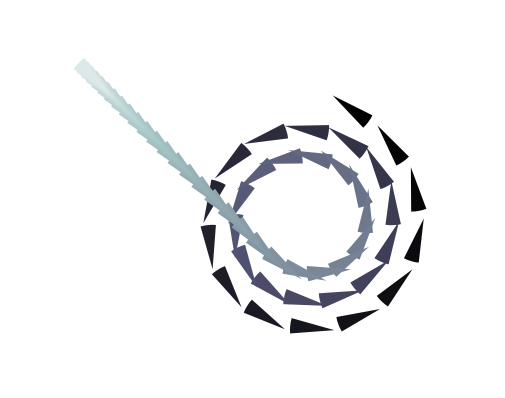

In [9]:
simulator.plot_trajectory(size_radius=0.2, nskip=1)

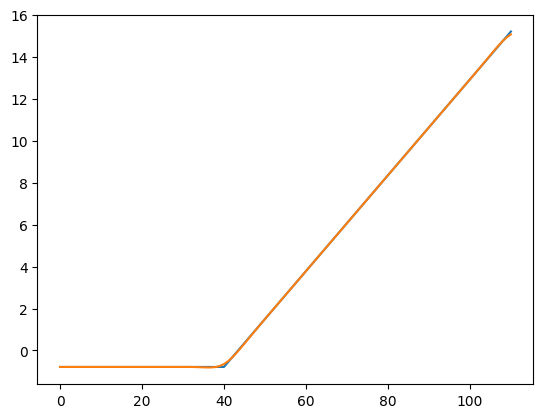

In [10]:
# Compare the commanded vs. actual heading
plt.plot(psi)
plt.plot(y_sim['psi'])

# Compute observability


In [11]:
win = 5  # window size, set to None to use entire time-series as one window

In [12]:
# Construct O in sliding windows
# Compute observability in polar coordinates by providing the transformation function z_function and state names
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=win, eps=1e-4,
                                           z_function=simulator.dynamics.z_function,
                                           z_state_names=simulator.dynamics.state_names_polar)

In [13]:
# Get O's
O_sliding = SEOM.get_observability_matrix()
n_window = len(O_sliding)
print(n_window, 'windows')

107 windows


In [14]:
O_sliding[0]

,,x,y,z,g,beta,v_z,psi,w,zeta,k_x,k_y,k_psi
sensor,time_step,,,,,,,,,,,,
x,0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0
y,0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0
z,0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0
v_x,0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0
v_y,0,0.0,0.0,0.0,0.000000,0.100000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
a_y,4,0.0,0.0,0.0,0.000000,0.100000,0.0,-0.707107,-7.071068e-01,0.707107,0.000000,0.0,0.0
a,4,0.0,0.0,0.0,0.767698,-0.064081,0.0,-0.089721,9.959669e-01,0.089721,0.030717,0.0,0.0
gamma,4,0.0,0.0,0.0,0.580733,0.069572,0.0,-0.902591,-8.130954e-02,0.902591,0.023236,0.0,0.0


In [15]:
# Set each sensor noise level
R = 0.01  # set all sensors to this value
R = {'psi': R, 'r_x': R, 'r_y': R, 'a_x': R, 'a_y': R, 'u_x': R, 'u_y': R, 'u_psi': R}
# R = {'psi': 0.1, 'r_x': 0.1, 'r_y': 0.1, 'a_x': 0.1, 'a_y': 0.1, 'u_x': 0.1, 'u_y': 0.1, 'u_psi': 0.1}

# Choose sensors to use from O
o_sensors = ['psi', 'r_x', 'r_y', 'a_x', 'a_y']

# get unique combinations of sensors
o_sensors = consensus.uniqueSensorCombos(o_sensors)

# Chose states to use from O
# o_states = None  # None to use all states, otherwise specify a list of states to use
o_states = list(O_sliding[0].columns)[0:9]  # to not use the motor calibration states

# Choose time-steps to use from O
window_size = 4
o_time_steps = np.arange(0, window_size, step=1)

EV_all = []
for i in range(len(o_sensors)):
    # Compute the Fisher information & inverse for each window and store the minimum error variance
    SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=R,
                                    states=o_states, sensors=o_sensors[i], time_steps=o_time_steps, w=None)

    # Pull out minimum error variance
    # 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
    EV_aligned = SFO.get_minimum_error_variance()
    EV_all.append(EV_aligned)

In [16]:
# print(EV_all[0])
# print(len(EV_all))

# Plot state observability


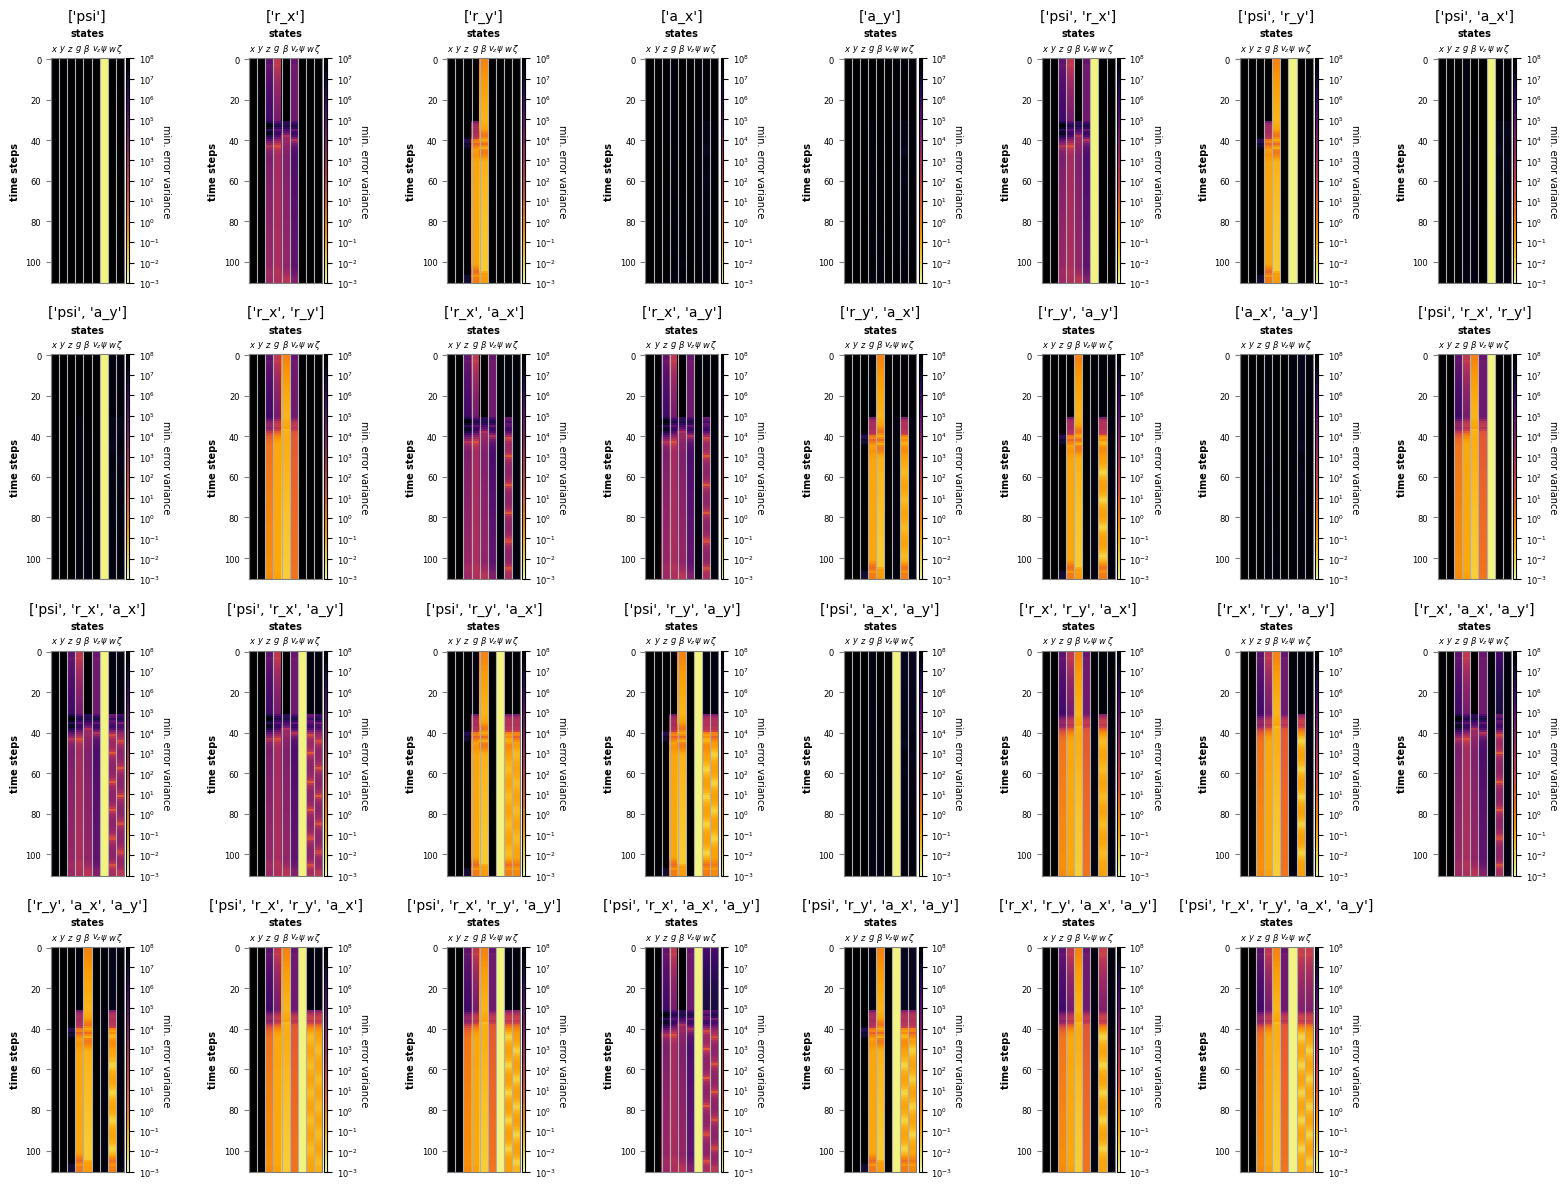

In [17]:
# for i in range(len(EV_all)):
#     EV = EV_all[i].iloc[:, 2:]
#     error_variance = EV.ffill().bfill()
#     cnorm, cmap, log_ticks = ff.plot_heatmap_log_timeseries(error_variance.values, data_labels=list(EV.columns),
#                                                             log_ticks=(-3, 8), y_label='min. error variance')

n = len(EV_all)  # number of sensor combinations
cols = 8
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 3 * rows))
axes = axes.flatten()  # Flatten in case it's a 2D array

cnorm_all = []
cmap_all = []

for i in range(n):
    EV = EV_all[i].iloc[:, 2:]
    error_variance = EV.ffill().bfill()
    
    ax = axes[i]
    cnorm, cmap, log_ticks = ff.plot_heatmap_log_timeseries(
        error_variance.values,
        data_labels=list(EV.columns),
        log_ticks=(-3, 8),
        y_label='min. error variance',
        ax=ax  # Pass the subplot axis
    )
    ax.set_title(f'{o_sensors[i]}', fontsize=10)

    cnorm_all.append(cnorm)
    cmap_all.append(cmap)

# Hide any unused subplots
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Plot state observability on trajectory


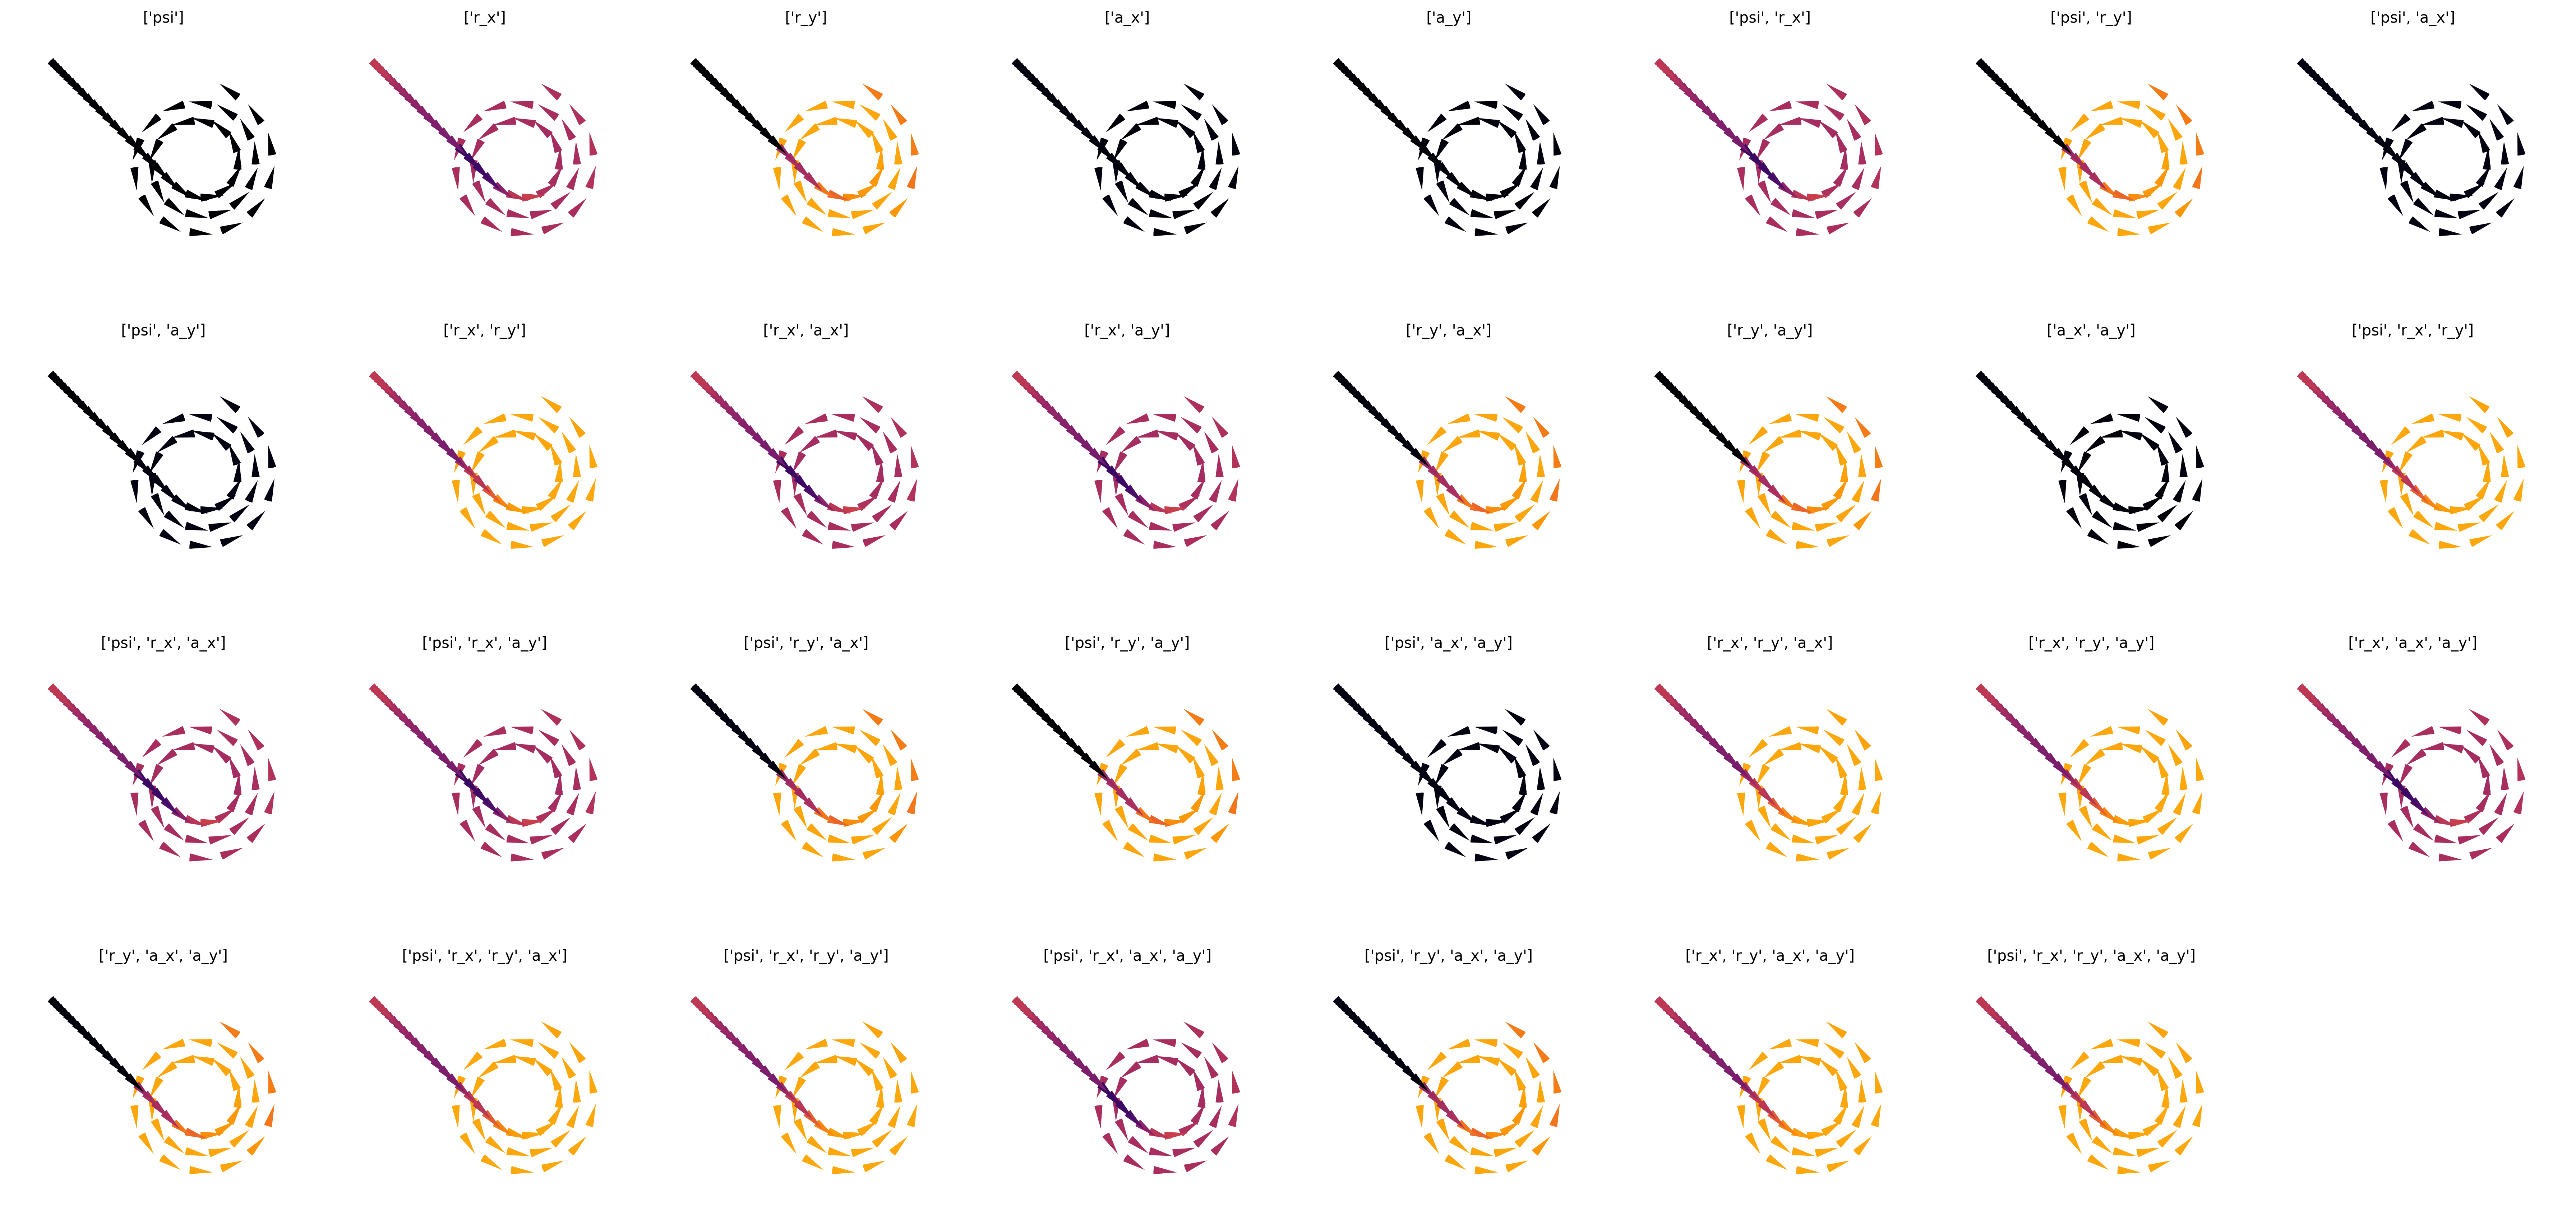

In [49]:
n = len(EV_all)  # number of sensor combinations
cols = 8
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows), sharex=True, sharey=True, dpi=300)
axes = axes.flatten()

o_var = 'g'  # or any other state you want to visualize

for i in range(n):
    EV = EV_all[i].iloc[:, 2:]
    error_variance = EV.ffill().bfill()
    # Use the same colormap and normalization as before, or recompute if needed
    ax = axes[i]
    ff.plot_trajectory(
        y_sim['x'], y_sim['y'], y_sim['psi'],
        color=error_variance[o_var].values,
        ax=ax,
        size_radius=0.16,
        nskip=1,
        colormap=cmap_all[i] if 'cmap_all' in locals() else cmap,
        colornorm=cnorm_all[i] if 'cnorm_all' in locals() else cnorm
    )
    ax.set_title(f"{o_sensors[i]}", fontsize=10)
    ax.set_axis_off()

# Hide any unused subplots
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Set up EKF

In [19]:
from model.drone_ekf import DroneEKF

In [20]:
# Set measurement names
measurement_names = o_sensors.copy()
measurement_names

[['psi'],
 ['r_x'],
 ['r_y'],
 ['a_x'],
 ['a_y'],
 ['psi', 'r_x'],
 ['psi', 'r_y'],
 ['psi', 'a_x'],
 ['psi', 'a_y'],
 ['r_x', 'r_y'],
 ['r_x', 'a_x'],
 ['r_x', 'a_y'],
 ['r_y', 'a_x'],
 ['r_y', 'a_y'],
 ['a_x', 'a_y'],
 ['psi', 'r_x', 'r_y'],
 ['psi', 'r_x', 'a_x'],
 ['psi', 'r_x', 'a_y'],
 ['psi', 'r_y', 'a_x'],
 ['psi', 'r_y', 'a_y'],
 ['psi', 'a_x', 'a_y'],
 ['r_x', 'r_y', 'a_x'],
 ['r_x', 'r_y', 'a_y'],
 ['r_x', 'a_x', 'a_y'],
 ['r_y', 'a_x', 'a_y'],
 ['psi', 'r_x', 'r_y', 'a_x'],
 ['psi', 'r_x', 'r_y', 'a_y'],
 ['psi', 'r_x', 'a_x', 'a_y'],
 ['psi', 'r_y', 'a_x', 'a_y'],
 ['r_x', 'r_y', 'a_x', 'a_y'],
 ['psi', 'r_x', 'r_y', 'a_x', 'a_y']]

In [21]:
# Initialize the EKF
EKFs = []  # List to hold EKF instances
for i in range(len(measurement_names)):
    EKF = DroneEKF(dt=dt, measurement_names=measurement_names[i])
    EKFs.append(EKF)

In [22]:
# Add some extra variables & wrap angular ones
sim_data['beta'] = util.wrapToPi(sim_data['beta'].values)
sim_data['gamma'] = util.wrapToPi(sim_data['gamma'].values)
sim_data['psi_dot'] = sim_data['u_psi'].values
sim_data['w_x_dot'] = pynumdiff.smooth_finite_difference.gaussiandiff(sim_data['w_x'].values, 0.1, [20])[1]
sim_data['w_y_dot'] = pynumdiff.smooth_finite_difference.gaussiandiff(sim_data['w_y'].values, 0.1, [20])[1]

In [23]:
EKFs[0].state_names

('z', 'v_x', 'v_y', 'psi', 'w_x', 'w_y', 'w_x_dot', 'w_y_dot')

In [24]:
# Get the ground truth states, inputs, and measurements
x_ekf_all = []
u_ekf_all = []
y_ekf_all = []

for i in range(len(EKFs)):
    x_ekf = sim_data.loc[:, EKFs[i].state_names].copy()
    u_ekf = sim_data.loc[:, EKFs[i].input_names].copy()
    y_ekf = sim_data.loc[:, EKFs[i].measurement_names].copy()

    x_ekf_all.append(x_ekf)
    u_ekf_all.append(u_ekf)
    y_ekf_all.append(y_ekf)

# Simulate using EKF model
Make sure the EKF model matches the model used for the simulation

The following plots should perfectly overlap

In [25]:
t_sim_ekf_all = []
x_sim_ekf_all = []
u_sim_ekf_all = []
y_sim_ekf_all = []

for i in range(len(EKFs)):
    t_sim_ekf, x_sim_ekf, u_sim_ekf, y_sim_ekf = EKFs[i].simulate(x_ekf_all[i], u_ekf_all[i])
    t_sim_ekf_all.append(t_sim_ekf)
    x_sim_ekf_all.append(x_sim_ekf)
    u_sim_ekf_all.append(u_sim_ekf)
    y_sim_ekf_all.append(y_sim_ekf)

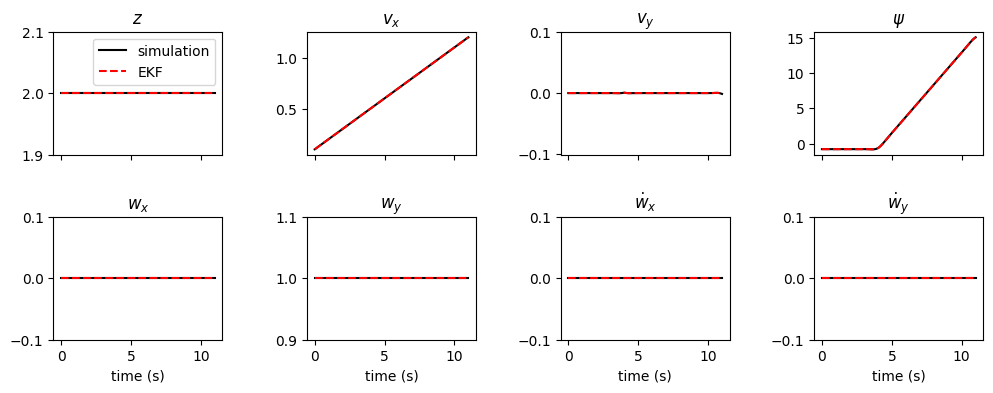

In [26]:
# State comparison
index_to_test = 30

n_col = 4
n_row = int(np.ceil(EKFs[index_to_test].n/n_col))
fig, axs = plt.subplots(nrows=n_row, ncols=n_col, sharex=True, figsize=(3.0*n_col, 2.0*n_row), squeeze=False)
latex = ff.LatexStates()
for i, x in enumerate(x_sim_ekf_all[index_to_test].keys()):
    ax = axs.flat[i]
    ax.set_title(latex.convert_to_latex(x))
    ax.plot(t_sim_ekf_all[index_to_test], x_ekf_all[index_to_test][x].values, label='simulation', color='black')
    ax.plot(t_sim_ekf_all[index_to_test], x_sim_ekf_all[index_to_test][x].values, label='EKF', color='red', linestyle='--')

    lim = np.hstack((x_ekf_all[index_to_test][x].values, x_sim_ekf_all[index_to_test][x].values))
    if (lim.max() - lim.min()) < 0.1:
        ax.set_ylim(lim.min() - 0.1, lim.max() + 0.1)

axs.flat[0].legend()

for ax in axs[-1, :].flat:
    ax.set_xlabel('time (s)')

fig.subplots_adjust(hspace=0.5, wspace=0.5)

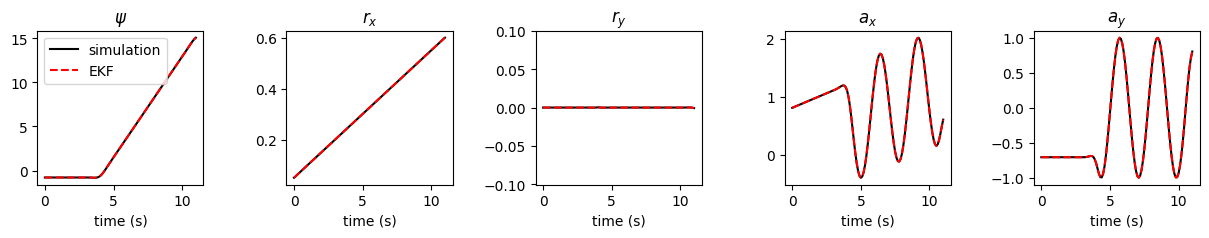

In [27]:
# Measurement comparison
n_col = EKFs[index_to_test].p
n_row = int(np.ceil(EKFs[index_to_test].p/n_col))
fig, axs = plt.subplots(nrows=n_row, ncols=n_col, sharex=True, figsize=(3.0*n_col, 2.0*n_row), squeeze=False)
latex = ff.LatexStates()
for i, x in enumerate(y_sim_ekf_all[index_to_test].keys()):
    ax = axs.flat[i]
    ax.set_title(latex.convert_to_latex(x))
    ax.plot(t_sim_ekf_all[index_to_test], sim_data[x].values, label='simulation', color='black')
    ax.plot(t_sim_ekf_all[index_to_test], y_sim_ekf_all[index_to_test][x].values, label='EKF', color='red', linestyle='--')

    lim = np.hstack((sim_data[x].values, y_sim_ekf_all[index_to_test][x].values))
    if (lim.max() - lim.min()) < 0.1:
        ax.set_ylim(lim.min() - 0.1, lim.max() + 0.1)

axs.flat[0].legend()

for ax in axs[-1, :].flat:
    ax.set_xlabel('time (s)')

fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Add noise

In [28]:
# Set the noise for every potential measurement & input
measurement_noise_cov = R.copy()

# base_noise = 1.0
# measurement_noise_cov = {'z': base_noise * 1e0,
#                          'v_y': base_noise * 1e0,
#                          'v_x_dot': base_noise * 1e0,
#                          'v_y_dot': base_noise * 1e0,
#                          'psi': base_noise * 1e-1,
#                          'psi_dot': base_noise * 1e-1,
#                          'beta': base_noise * 1e0,
#                          'gamma': base_noise * 1e0,
#                          'g': base_noise * 1e0,
#                          'a': base_noise * 1e0,
#                          'a_x': base_noise * 1e-1,
#                          'a_y': base_noise * 1e-1,
#                          'r': base_noise * 1e-1,
#                          'r_x': base_noise * 1e-1,
#                          'r_y': base_noise * 1e-1,
#                          'u_x': base_noise * 1e-1,
#                          'u_y': base_noise * 1e-1,
#                          'u_psi': base_noise * 1e-1
#                          }

In [29]:
# Measurement noise
R_noise_all = []
U_noise_all = []

for i in range(len(EKFs)):
    EKF = EKFs[i]
    R_noise = pd.DataFrame(np.zeros((EKF.p, EKF.p)),
                        index=EKF.measurement_names,
                        columns=EKF.measurement_names)

    for c in EKF.measurement_names:
        R_noise.loc[c, c] = measurement_noise_cov[c]

    # Input noise
    U_noise = pd.DataFrame(np.zeros((EKF.m, EKF.m)),
                        index=EKF.input_names,
                        columns=EKF.input_names)

    for c in EKF.input_names:
        U_noise.loc[c, c] = measurement_noise_cov[c]

    R_noise_all.append(R_noise)
    U_noise_all.append(U_noise)

In [30]:
# Add noise to data to measurements
y_ekf_noise_all = []
u_ekf_noise_all = []

for i in range(len(EKFs)):
    EKF = EKFs[i]
    R_noise = R_noise_all[i]
    U_noise = U_noise_all[i]
    np.random.seed(seed=1)
    measurement_noise = np.random.multivariate_normal(mean=np.zeros(EKF.p),
                                                      cov=R_noise,
                                                      size=sim_data.shape[0])
    measurement_noise = pd.DataFrame(measurement_noise, columns=EKF.measurement_names)

    y_ekf_noise = y_ekf_all[i].copy()
    for c in EKF.measurement_names:
        y_ekf_noise[c] = y_ekf_noise[c].values + measurement_noise[c]

    input_noise = np.random.multivariate_normal(mean=np.zeros(EKF.m),
                                                cov=U_noise,
                                                size=sim_data.shape[0])
    input_noise = pd.DataFrame(input_noise, columns=EKF.input_names)

    u_ekf_noise = u_ekf_all[i].copy()
    for c in EKF.input_names:
        u_ekf_noise[c] = u_ekf_noise[c].values + input_noise[c]

    y_ekf_noise_all.append(y_ekf_noise)
    u_ekf_noise_all.append(u_ekf_noise)

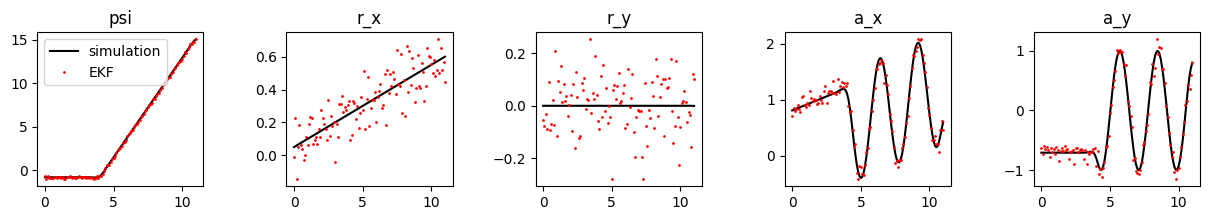

In [31]:
index_to_test = 30  # or any EKF index you want to plot

y_ekf_noise = y_ekf_noise_all[index_to_test]
u_ekf_noise = u_ekf_noise_all[index_to_test]
y_ekf = y_ekf_all[index_to_test]
EKF = EKFs[index_to_test]

n_col = EKF.p
n_row = int(np.ceil(EKF.p / n_col))
fig, ax = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3.0*n_col, 2.0*n_row))
axes = np.atleast_1d(ax).flat

for i, x in enumerate(y_ekf.keys()):
    if i >= len(list(axes)):
        break
    axes[i].set_title(x)
    axes[i].plot(t_sim, sim_data[x].values, label='simulation', color='black')
    axes[i].plot(t_sim, y_ekf_noise[x].values, label='EKF', color='red', linestyle='none',
                 marker='.', markersize=4, markeredgecolor='none')
    lim = np.hstack((sim_data[x].values, y_ekf_noise[x].values))
    if (lim.max() - lim.min()) < 0.1:
        axes[i].set_ylim(lim.min() - 0.1, lim.max() + 0.1)

axes[0].legend()
fig.subplots_adjust(hspace=0.5, wspace=0.5)

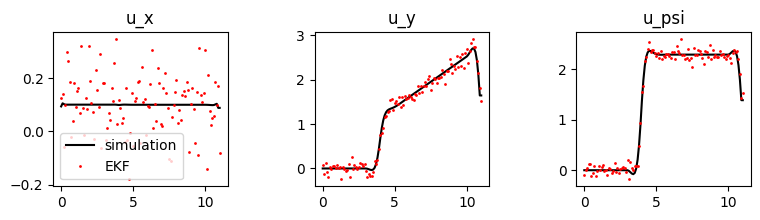

In [32]:
# Plot noisy inputs
index_to_test = 0  # or any EKF index you want to plot

y_ekf_noise = y_ekf_noise_all[index_to_test]
u_ekf_noise = u_ekf_noise_all[index_to_test]
y_ekf = y_ekf_all[index_to_test]
EKF = EKFs[index_to_test]

n_col = 3
n_row = int(np.ceil(EKF.m/n_col))
fig, ax = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3.0*n_col, 2.0*n_row))
for i, x in enumerate(u_ekf.keys()):
    ax.flat[i].set_title(x)
    ax.flat[i].plot(t_sim, sim_data[x].values, label='simulation', color='black')
    ax.flat[i].plot(t_sim, u_ekf_noise[x].values, label='EKF', color='red', linestyle='none',
                    marker='.', markersize=4, markeredgecolor='none')

    lim = np.hstack((sim_data[x].values, u_ekf_noise[x].values))
    if (lim.max() - lim.min()) < 0.1:
        ax.flat[i].set_ylim(lim.min() - 0.1, lim.max() + 0.1)

ax.flat[0].legend()
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Run EKF


In [33]:
# Set initial condition
x0_all = []
for i in range(len(EKFs)):
    # Try to get psi from measurements, else fallback to sim_data
    if 'psi' in y_ekf_all[i].columns:
        psi0 = y_ekf_all[i]['psi'].values[0]
    else:
        psi0 = sim_data['psi'].values[0]  # fallback to true value

    x0 = {
        'z': 3.1,
        'v_x': 0.5,
        'v_y': 0.1,
        'psi': psi0,
        'w_x': 0.0,
        'w_y': 0.0,
        'w_x_dot': 0.0,
        'w_y_dot': 0.0
    }
    x0_all.append(x0)

In [34]:
# Set initial state covariance
P0 = {'z': 1e1,
      'v_x': 1e1,
      'v_y': 1e1,
      'psi': 1e-1,
      'w_x': 1e1,
      'w_y': 1e1,
      'w_x_dot': 1e1,
      'w_y_dot': 1e1
      }

In [35]:
# Set process noise covariance
q0 = 1e-4
Q0 = {'z': q0 * 1e0,
      'v_x': q0 * 1e0,
      'v_y': q0 * 1e0,
      'psi': q0 * 1e0,
      'w_x': q0 * 1e-2,
      'w_y': q0 * 1e-2,
      'w_x_dot': q0 * 1e-2,
      'w_y_dot': q0 * 1e-2,
      }

In [36]:
# Set measurement noise covariance
R0_all = []
for i in range(len(EKFs)):
    R0 = R_noise_all[i].copy()  # This will match R to the added noise
    R0_all.append(R0)
# r0 = 1e-0
# R0 = {'z': r0 * 1e-2,
#       'v_x': r0 * 1e-2,
#       'v_y': r0 * 1e-2,
#       'v_x_dot': r0 * 1e-2,
#       'v_y_dot': r0 * 1e-2,
#       'psi': r0 * 1e-2,
#       'psi_dot': r0 * 1e-2,
#       'beta': r0 * 1e-2,
#       'gamma': r0 * 1e-2,
#       'g': r0 * 1e-2,
#       'a': r0 * 1e-2,
#       'r': r0 * 1e-2,
#       }

In [37]:
print(measurement_names)

[['psi'], ['r_x'], ['r_y'], ['a_x'], ['a_y'], ['psi', 'r_x'], ['psi', 'r_y'], ['psi', 'a_x'], ['psi', 'a_y'], ['r_x', 'r_y'], ['r_x', 'a_x'], ['r_x', 'a_y'], ['r_y', 'a_x'], ['r_y', 'a_y'], ['a_x', 'a_y'], ['psi', 'r_x', 'r_y'], ['psi', 'r_x', 'a_x'], ['psi', 'r_x', 'a_y'], ['psi', 'r_y', 'a_x'], ['psi', 'r_y', 'a_y'], ['psi', 'a_x', 'a_y'], ['r_x', 'r_y', 'a_x'], ['r_x', 'r_y', 'a_y'], ['r_x', 'a_x', 'a_y'], ['r_y', 'a_x', 'a_y'], ['psi', 'r_x', 'r_y', 'a_x'], ['psi', 'r_x', 'r_y', 'a_y'], ['psi', 'r_x', 'a_x', 'a_y'], ['psi', 'r_y', 'a_x', 'a_y'], ['r_x', 'r_y', 'a_x', 'a_y'], ['psi', 'r_x', 'r_y', 'a_x', 'a_y']]


In [38]:
# Run KF
# x_est, x_cov, r_cov, y_noise = EKF.run_ekf(x0, u_ekf_noise, y_ekf_noise,
#                                            P_init=P0,
#                                            Q_init=Q0,
#                                            R_sim=R0)
x_est_all = []
x_cov_all = []
r_cov_all = []
y_noise_all = []

for i in range(len(EKFs)):
    EKF = EKFs[i]
    x_est, x_cov, r_cov, y_noise = EKF.run_ekf(x0_all[i], u_ekf_noise_all[i], y_ekf_noise_all[i],
                                               P_init=P0,
                                               Q_init=Q0,
                                               R_sim=R0_all[i])
    x_est_all.append(x_est)
    x_cov_all.append(x_cov)
    r_cov_all.append(r_cov)
    y_noise_all.append(y_noise)

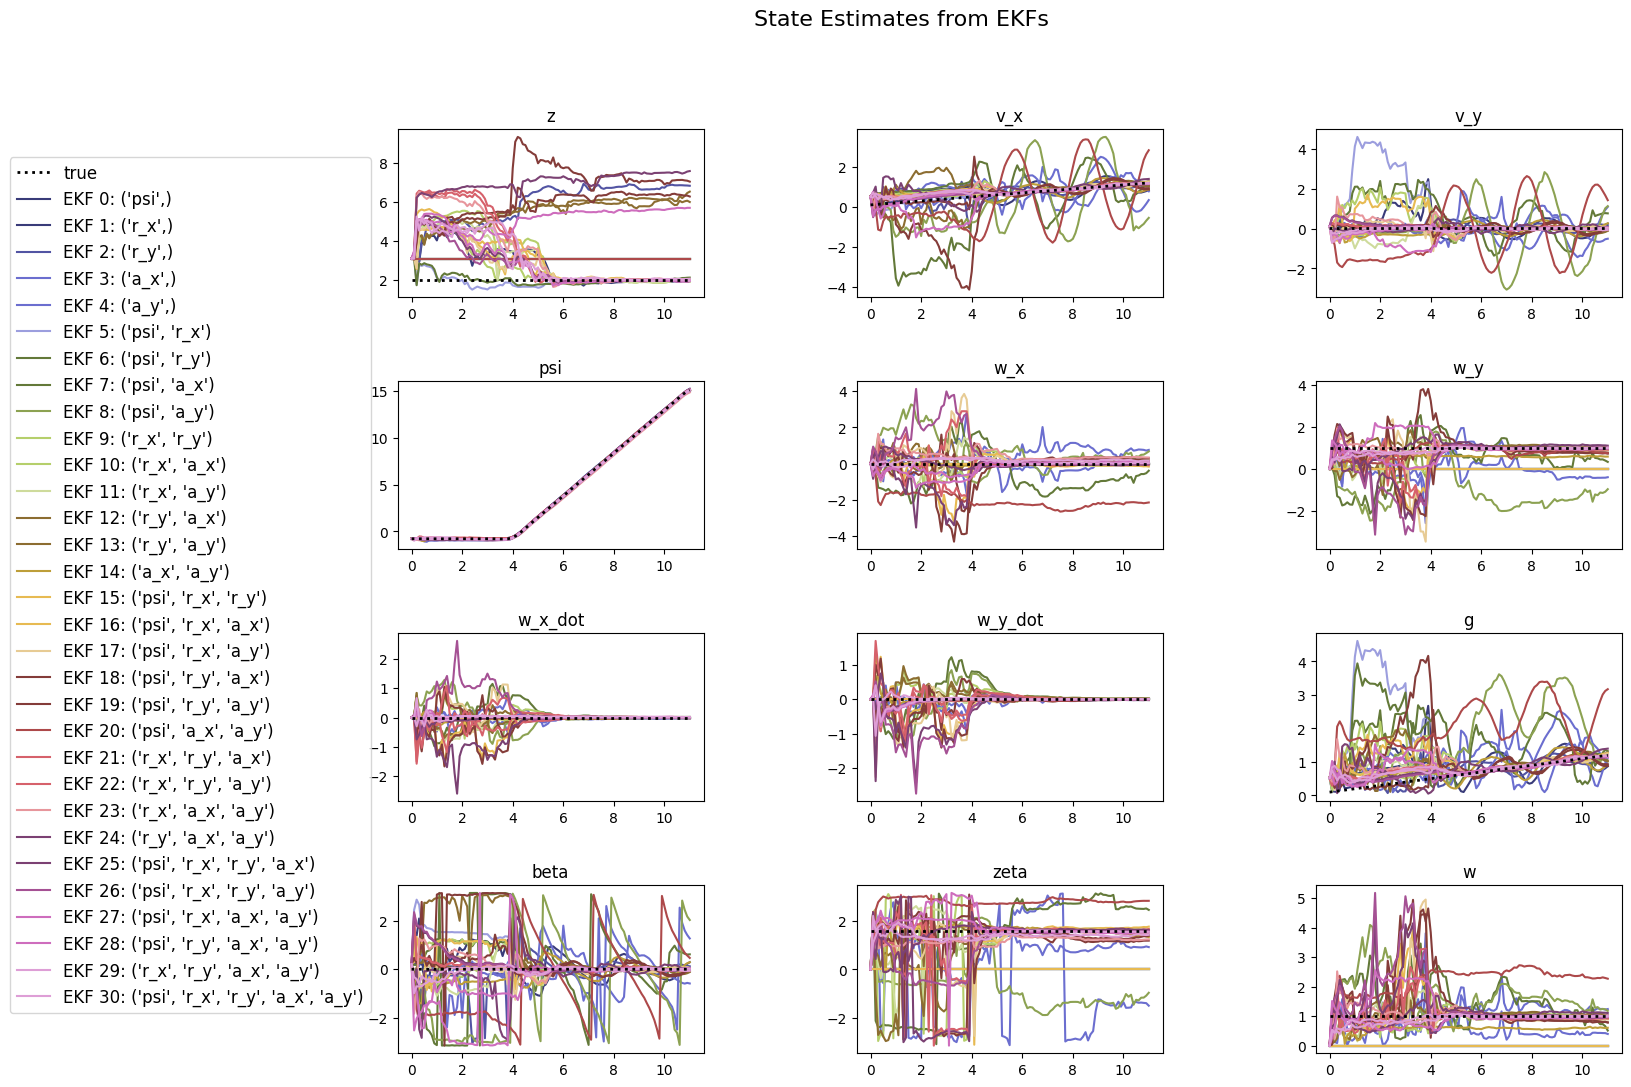

In [39]:
from utils.consensus import plotStateEstimates

# index = [0, 1]
# make a list from 0 to 30
index = list(range(len(EKFs)))
plotStateEstimates(index, EKFs, x_est_all, x_cov_all, t_sim_ekf_all, sim_data)

# Sort out Unobservable Cases

In [44]:
# print covariance of the first EKF

print(x_est_all[1])

            z       v_x       v_y        psi  w_x  w_y  w_x_dot  w_y_dot  \
0    3.100000  0.511570  0.112809  -0.793993  0.0  0.0      0.0      0.0   
1    3.112647  0.523030 -0.186135  -0.802588  0.0  0.0      0.0      0.0   
2    3.232552  0.537550 -0.183245  -0.802975  0.0  0.0      0.0      0.0   
3    2.947701  0.572169 -0.221695  -0.798886  0.0  0.0      0.0      0.0   
4    4.098701  0.051857 -0.141533  -0.786149  0.0  0.0      0.0      0.0   
..        ...       ...       ...        ...  ...  ...      ...      ...   
106  6.865733  1.073776  0.216206  14.404109  0.0  0.0      0.0      0.0   
107  6.862873  1.129255  0.212614  14.640594  0.0  0.0      0.0      0.0   
108  6.854200  1.192918  0.193456  14.859842  0.0  0.0      0.0      0.0   
109  6.849863  1.238349  0.176364  15.049050  0.0  0.0      0.0      0.0   
110  6.837079  1.284235  0.157032  15.191977  0.0  0.0      0.0      0.0   

            g      beta  zeta    w  
0    0.523861  0.217042   0.0  0.0  
1    0.555163

In [48]:
from utils.consensus import ignoreUnobservableCases

trustworthy_combos = ignoreUnobservableCases(EKFs, x_est_all, x_cov_all)

estiamted states:  ['z', 'v_x', 'v_y', 'psi', 'w_x', 'w_y', 'w_x_dot', 'w_y_dot']
{'z': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'v_x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'v_y': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'psi': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'w_x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'w_y': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'w_x_dot': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'w_y_dot': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 